In [ ]:
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect, LangDetectException
from reviews_cleaning import DataCleaner

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/amazon.csv')

In [3]:
df.head(3)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...


In [4]:
# Basic info
print("Dataset Info:")
print(df.info())
print("===============================================================================")


print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   obje

In [ ]:
- Only rating_count has two NaNs

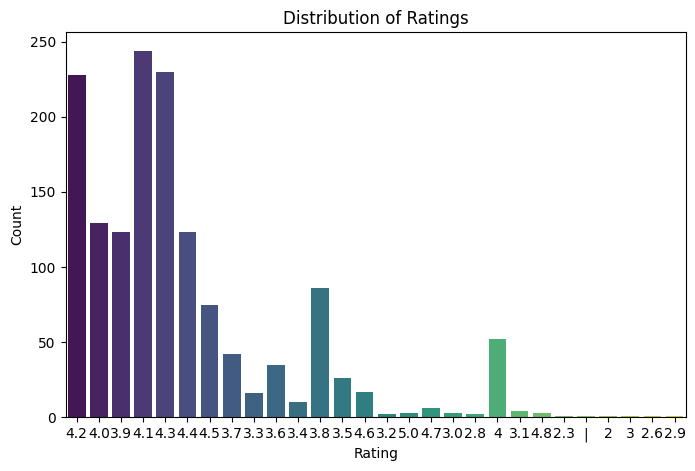

In [5]:
# 1. Distribution of Star Ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [ ]:
- Above we see rating ranges from 1 to 5 with data quality issues where we have a value '|'. Below we clean it and cast to float to see the correct distribution 

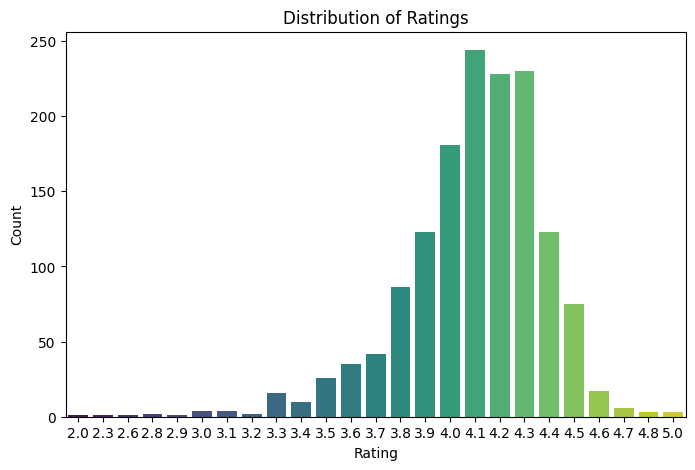

In [6]:
df = df[df['rating']!='|']
df['rating'] = df['rating'].astype('float64')
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
#### Product Review count

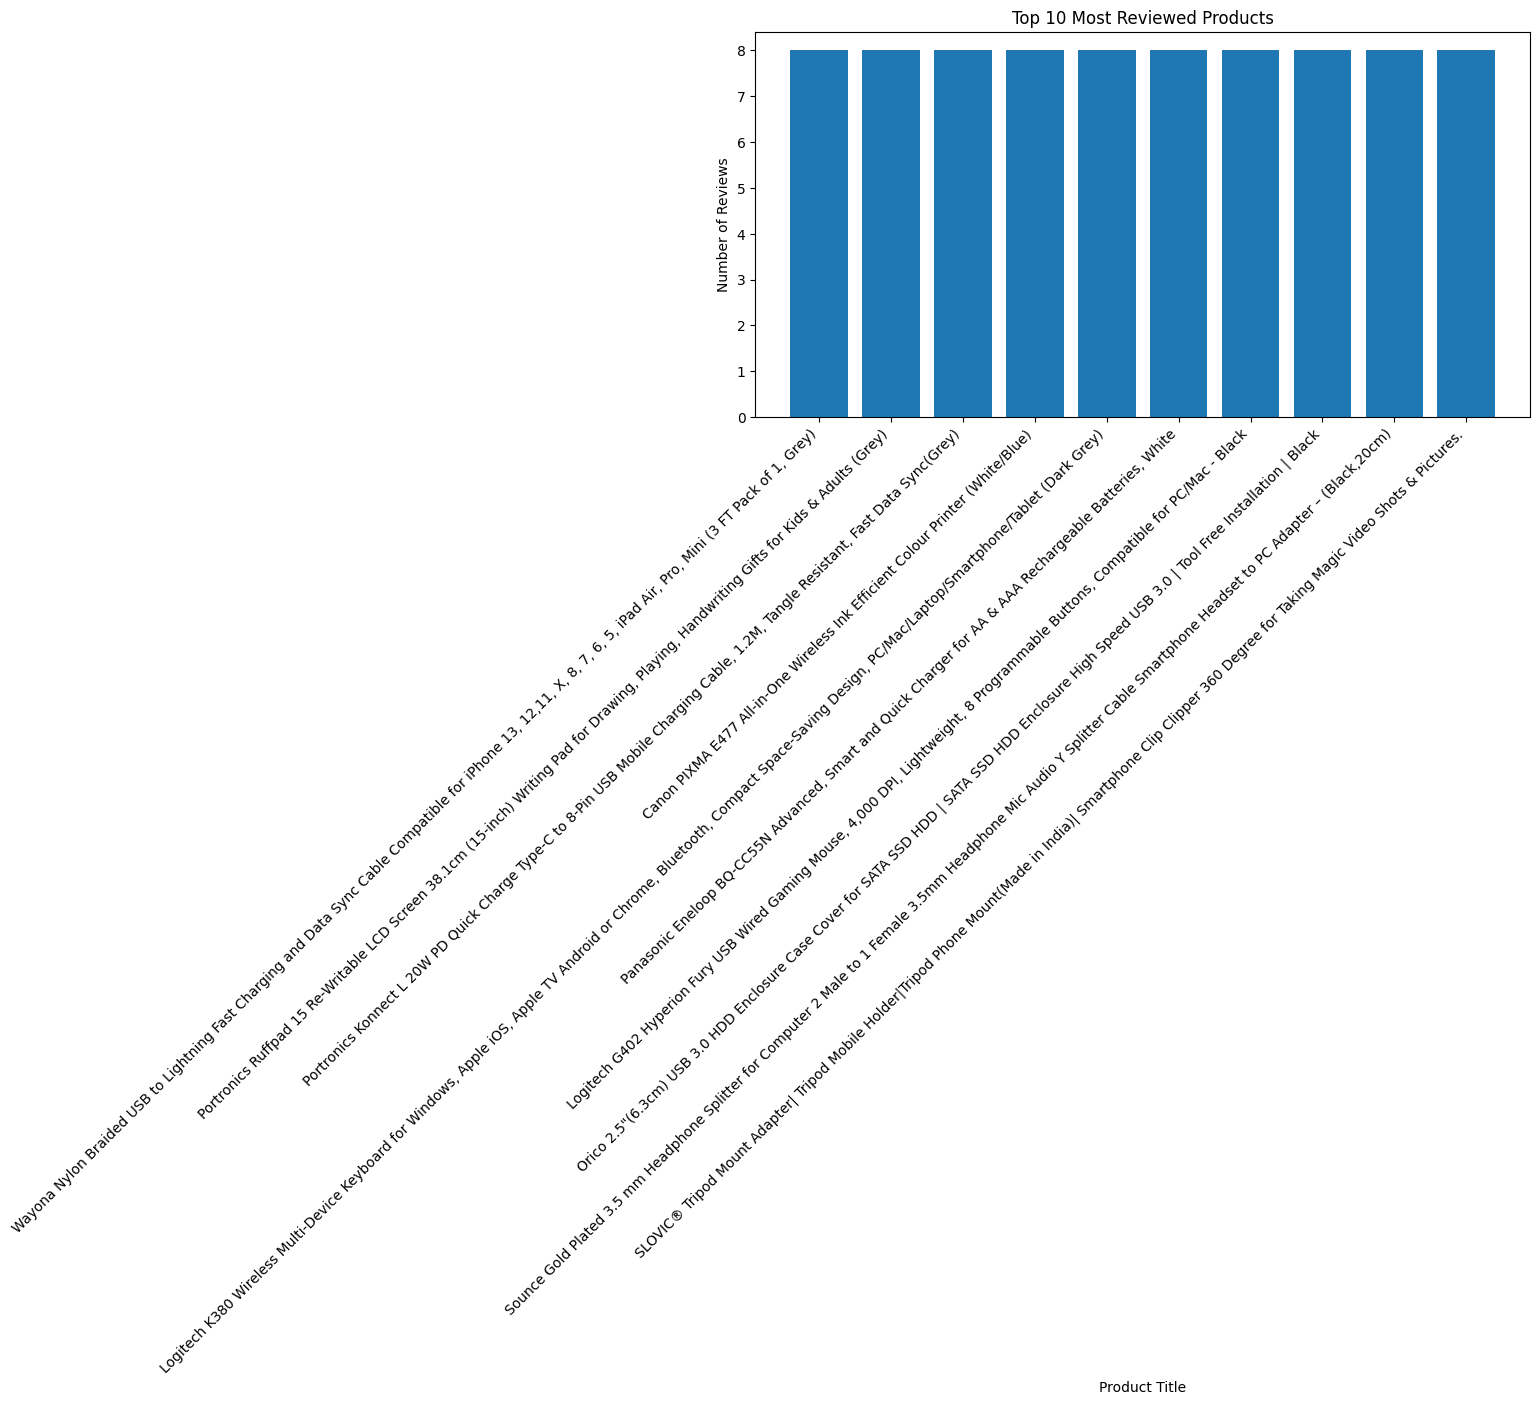

In [7]:
# 4. Top 10 Most Reviewed Products
df["review_count"] = df["review_id"].str.split(",").str.len()
top_10 = df.sort_values("review_count", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(top_10["product_name"], top_10["review_count"])
plt.xlabel("Product Title")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Most Reviewed Products")
plt.xticks(rotation=45, ha='right')
plt.show()


## Clean the review_content

Review content column contains all reviews for a product separated by a comma, I product can have one or many reviews

#### (a) products with only one review

In [8]:
single_review_df = df[df['review_count']==1]
print(single_review_df.shape)
single_review_df[['product_id', 'review_content']]

(4, 17)


,product_id,review_content
155,B09XJ1LM7R,"tv on off not working, so difficult to battery..."
282,B0B94JPY2N,I have a pd supported car charger and I bought...
324,B0BQRJ3C47,Quick delivery.Awesome ProductPacking was good...
1459,B0B3JSWG81,Does not work as advertised at all. The pieces...


#### (b) products with multiple reviews

In [9]:
multiple_reviews_df = df[df['review_count']!=1]
print(multiple_reviews_df.shape)
multiple_reviews_df[['product_id', 'review_content']].head()

(1460, 17)


,product_id,review_content
0,B07JW9H4J1,Looks durable Charging is fine tooNo complains...
1,B098NS6PVG,I ordered this cable to connect my phone to An...
2,B096MSW6CT,"Not quite durable and sturdy,https://m.media-a..."
3,B08HDJ86NZ,"Good product,long wire,Charges good,Nice,I bou..."
4,B08CF3B7N1,"Bought this instead of original apple, does th..."


##### Here we can only already see a potential data issue in the reviews where it contains links to products. See below. 

In [10]:
pd.set_option("display.max_colwidth", None)
print(df[df['product_id']== 'B096MSW6CT']['review_content'])
pd.reset_option("display.max_colwidth")

2      Not quite durable and sturdy,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/71rIggrbUCL._SY88.jpg,Working good,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/61bKp9YO6wL._SY88.jpg,Product,Very nice product,Working well,It's a really nice product
379                                                    Not quite durable and sturdy,https://m.media-amazon.com/images/I/71rIggrbUCL._SY88.jpg,Working good,https://m.media-amazon.com/images/I/61bKp9YO6wL._SY88.jpg,Product,Very nice product,Working well,It's a really nice product
623    Not quite durable and sturdy,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/71rIggrbUCL._SY88.jpg,Working good,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/61bKp9YO6wL._SY88.jpg,Product,Very nice product,Working well,It's a really nice product
Name: review_content, dtype: object


##### We also see from above that not only does the review contain product image links but its also duplicated

In [11]:
dup_mask = df.duplicated(
    subset=["product_id", "user_id", "review_content", "review_id"],
    keep=False
)
print(df[dup_mask].shape)
df[dup_mask].head(3)

(173, 17)


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,review_count
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,8
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,8
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,8


In [12]:
### We have 173 duplicate records which we are going to drop
df_deduped = df.drop_duplicates(
    subset=["product_id", "user_id", "review_content"],
    keep="first"
)
print(df.shape)
print(df_deduped.shape)

(1464, 17)
(1369, 17)


In [13]:
# Even after deduplication, some duplicate prodcuct_id still exists. This one here is because the review_content has
# 'spam' product image links. Lets see how thi behaves after removing the image links
pd.set_option("display.max_colwidth", None)
print(df_deduped[df_deduped['product_id']=='B096MSW6CT'][["review_content"]])
pd.reset_option("display.max_colwidth")

                                                                                                                                                                                                                                                                      review_content
2    Not quite durable and sturdy,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/71rIggrbUCL._SY88.jpg,Working good,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/61bKp9YO6wL._SY88.jpg,Product,Very nice product,Working well,It's a really nice product
379                                                  Not quite durable and sturdy,https://m.media-amazon.com/images/I/71rIggrbUCL._SY88.jpg,Working good,https://m.media-amazon.com/images/I/61bKp9YO6wL._SY88.jpg,Product,Very nice product,Working well,It's a really nice product


In [28]:
df_deduped = DataCleaner.remove_links_from_reviews(df_deduped, 'review_content')

pd.set_option("display.max_colwidth", None)
print(df_deduped[df_deduped['product_id']=='B096MSW6CT'][["review_content"]])
pd.reset_option("display.max_colwidth")

                                                                             review_content
2  Not quite durable and sturdy, good, nice product,Working well,It's a really nice product


In [15]:
## Nice one. After removing the spam links, now we have simillar reviews. We can now deduplicate
print(df_deduped.shape)
df_deduped = df_deduped.drop_duplicates(
    subset=["product_id", "user_id", "review_content"],
    keep="first"
)
print(df_deduped.shape)

(1369, 17)
(1360, 17)


##### Some reviews are in different languages is are not english.

In [27]:
pd.set_option("display.max_colwidth", None)
print(df_deduped[df_deduped['product_id']=='B08WRWPM22']['review_content'])
pd.reset_option("display.max_colwidth")

6    Build quality is good and it is comes with 2 year warranty.,Good Product,Bought it for charging my mobile & tab but it doesn't work for Lenovo m8 tab,Guys this cable is is best compare of everyone over heat protection, quickly charging, but chance to shock circuit,good,Nice,Good quality,1.5एम का डाटा केबल मेरे लिए बहुत ही लाभदायक है । मैं इस केबल को लाइन में चार्ज करते समय फोन बहुत आराम से उपयोग कर पा रहा हु । आप इस केबल से 15watt का चार्जर उसे कर सकते है (इससे जड़ा नही) । लोकल बाजार में इसका दाम 150 है , अमेजन पे ये केबल मुझे 67 में मिला । गर्व से कहो हम हिंदू है , जय हिंद जय भारत ,
Name: review_content, dtype: object


For this task, I will remove non English reviews so that the model doesn't learn garbage

In [17]:
def keep_english_sentences(text):
    if not isinstance(text, str):
        return text

    sentences = re.split(r'[.!?,]', text)
    english_sentences = []

    for s in sentences:
        s = s.strip()
        if len(s) < 5:
            continue

        try:
            lang = detect(s)
            if lang == "en":
                english_sentences.append(s)
        except LangDetectException:
            #logger.warning("Language detection failed for sentence: %s", s)
            continue
    return ". ".join(english_sentences)
df_deduped['review_content_en'] = df_deduped['review_content'].apply(keep_english_sentences)


In [19]:
pd.set_option("display.max_colwidth", None)
print(df_deduped[df_deduped['product_id']=='B08WRWPM22']['review_content_en'])
pd.reset_option("display.max_colwidth")

6    Build quality is good and it is comes with 2 year warranty. Good Product. Bought it for charging my mobile & tab but it doesn't work for Lenovo m8 tab. Guys this cable is is best compare of everyone over heat protection. quickly charging. but chance to shock circuit. Good quality
Name: review_content_en, dtype: object


In [ ]:
##### With the review_content now in english only. I now move to clean the reviews by removing punctuations, HTML Tags, Emojis among others

In [20]:
df_deduped['review_content_en'] = DataCleaner.standardize_text(df_deduped['review_content_en'])

In [21]:
df_deduped = DataCleaner.dropnull_with_guard(df_deduped)

In [ ]:
## Label Annotation

In [22]:
df_deduped=DataCleaner.add_sentiment_column(df_deduped)
df_deduped['sentiment'].value_counts()

sentiment
positive    1016
neutral      336
negative       6
Name: count, dtype: int64

The dataset is very imbalanced with very many positive labels, and very few neutral once. The model selection and 
and data spliting will have to keep into account this.

In [24]:
df.shape

(1464, 17)

- Some products only have one review
- This B08L12N5H1 product_id has an incorrect value in the label
- Some product reviews only have image links (remove them)
- Count number of users_ids in each review
- Confirm 2 products don't have same product links - Confim


# Other things that can be done next steps
- Alert only if duplicate % jumps vs previous run
- 

In [33]:
df[df['rating_count'].isna()]

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,review_count
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹999,80%,3.0,NaN,USB C to C Cable: This cable has type C connec...,AE7CFHY23VAJT2FI4NZKKP6GS2UQ,Pranav,RUB7U91HVZ30,The cable works but is not 65W as advertised,I have a pd supported car charger and I bought...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Amazon-Brand-Charging-Su...,1
324,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",Computers&Accessories|Accessories&Peripherals|...,₹249,₹999,75%,5.0,NaN,💎[The Fastest Charge] - This iPhone USB C cabl...,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,Awesome Product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...,1
